<a href="https://colab.research.google.com/github/keerthanamanavalan/Stock_Market_prediction/blob/main/Phase_3_Stock_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install alpha_vantage pandas matplotlib

In [ ]:
import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Initialize Alpha Vantage API (replace with your API key)
api_key = 'XOBJD041I3HQPZF4'
ts = TimeSeries(key=api_key, output_format='pandas')

def fetch_stock_data(symbol, interval='daily', outputsize='full'):
    """Fetch stock data from Alpha Vantage"""
    try:
        data, meta_data = ts.get_daily(symbol=symbol, outputsize=outputsize)
        data = data.rename(columns={
            '1. open': 'Open',
            '2. high': 'High',
            '3. low': 'Low',
            '4. close': 'Close',
            '5. volume': 'Volume'
        })
        data['Symbol'] = symbol
        return data
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

In [ ]:
#Preprocessing of data
def preprocess_data(data, symbol, lookback=60):
    """Preprocess stock data with feature engineering"""
    # Calculate technical indicators
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

    # Calculate RSI
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # Calculate MACD
    ema12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema12 - ema26
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Daily price changes and volatility
    data['Daily_Return'] = data['Close'].pct_change()
    data['Price_Range'] = data['High'] - data['Low']

    # Create lag features
    for i in range(1, lookback+1):
        data[f'Lag_{i}'] = data['Close'].shift(i)

    # Drop NA values created by indicators and lags
    data = data.dropna()

    return data

In [ ]:
#Preparing Data for modle training
def prepare_datasets(data, test_size=0.2, lookback=60):
    """Prepare train/test datasets for LSTM and XGBoost"""
    # Features and target
    features = data.drop(['Close', 'Symbol'], axis=1, errors='ignore')
    target = data['Close']

    # Split into train/test (maintaining temporal order)
    split_idx = int(len(data) * (1 - test_size))
    X_train, X_test = features.iloc[:split_idx], features.iloc[split_idx:]
    y_train, y_test = target.iloc[:split_idx], target.iloc[split_idx:]

    # Scale data for LSTM
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape for LSTM [samples, timesteps, features]
    X_train_lstm = []
    y_train_lstm = []
    for i in range(lookback, len(X_train_scaled)):
        X_train_lstm.append(X_train_scaled[i-lookback:i])
        y_train_lstm.append(y_train.iloc[i])
    X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)

    X_test_lstm = []
    y_test_lstm = []
    for i in range(lookback, len(X_test_scaled)):
        X_test_lstm.append(X_test_scaled[i-lookback:i])
        y_test_lstm.append(y_test.iloc[i])
    X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm)

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_lstm': X_train_lstm,
        'X_test_lstm': X_test_lstm,
        'y_train_lstm': y_train_lstm,
        'y_test_lstm': y_test_lstm,
        'scaler': scaler,
        'symbol': data['Symbol'].iloc[0]
    }

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#reshape is not required for XG bcs it uses a raw data for modele training
def build_lstm_model(input_shape):
    """Build LSTM model architecture"""
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [ ]:
#Model training for both LSTM and XGBoost
def train_models(data_dict, epochs=50, batch_size=32):
    """Train both LSTM and XGBoost models"""
    # LSTM Model
    lstm_model = build_lstm_model((data_dict['X_train_lstm'].shape[1], data_dict['X_train_lstm'].shape[2]))
    lstm_history = lstm_model.fit(
        data_dict['X_train_lstm'], data_dict['y_train_lstm'],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_dict['X_test_lstm'], data_dict['y_test_lstm']),
        verbose=1
    )

    # XGBoost Model
    xgb_model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        random_state=42
    )

    xgb_model.fit(
        data_dict['X_train'], data_dict['y_train'],
        eval_set=[(data_dict['X_test'], data_dict['y_test'])],
        verbose=False
    )

    return {
        'lstm_model': lstm_model,
        'xgb_model': xgb_model,
        'lstm_history': lstm_history
    }

In [ ]:
#Evaluating the trained model for both LSTM adn XGBoost
def evaluate_models(models, data_dict):
    """Evaluate model performance"""
    # LSTM Evaluation
    lstm_pred = models['lstm_model'].predict(data_dict['X_test_lstm'])
    lstm_mae = mean_absolute_error(data_dict['y_test_lstm'], lstm_pred)
    lstm_rmse = np.sqrt(mean_squared_error(data_dict['y_test_lstm'], lstm_pred))
    lstm_r2 = r2_score(data_dict['y_test_lstm'], lstm_pred)

    # XGBoost Evaluation
    xgb_pred = models['xgb_model'].predict(data_dict['X_test'])
    xgb_mae = mean_absolute_error(data_dict['y_test'], xgb_pred)
    xgb_rmse = np.sqrt(mean_squared_error(data_dict['y_test'], xgb_pred))
    xgb_r2 = r2_score(data_dict['y_test'], xgb_pred)

    return {
        'lstm_metrics': {'MAE': lstm_mae, 'RMSE': lstm_rmse, 'R2': lstm_r2},
        'xgb_metrics': {'MAE': xgb_mae, 'RMSE': xgb_rmse, 'R2': xgb_r2},
        'symbol': data_dict['symbol']
    }

In [ ]:
#Analyzing the predicted Stock for single and Multiple
def analyze_stock(symbol, lookback=60, epochs=50):
    """Complete analysis pipeline for a single stock"""
    print(f"\nAnalyzing {symbol}...")

    # Step 1: Fetch data
    raw_data = fetch_stock_data(symbol)
    if raw_data is None:
        return None

    # Step 2: Preprocess data
    processed_data = preprocess_data(raw_data, symbol, lookback)

    # Step 3: Prepare datasets
    data_dict = prepare_datasets(processed_data, lookback=lookback)

    # Step 4: Train models
    models = train_models(data_dict, epochs=epochs)

    # Step 5: Evaluate models
    results = evaluate_models(models, data_dict)

    return {
        'symbol': symbol,
        'models': models,
        'results': results,
        'data': data_dict
    }

def analyze_multiple_stocks(symbols, lookback=60, epochs=50):
    """Analyze multiple stocks and compare results"""
    all_results = []

    for symbol in symbols:
        result = analyze_stock(symbol, lookback, epochs)
        if result is not None:
            all_results.append(result)

    # Compare results across all stocks
    comparison = pd.DataFrame([{
        'Symbol': r['symbol'],
        'LSTM_MAE': r['results']['lstm_metrics']['MAE'],
        'LSTM_RMSE': r['results']['lstm_metrics']['RMSE'],
        'LSTM_R2': r['results']['lstm_metrics']['R2'],
        'XGB_MAE': r['results']['xgb_metrics']['MAE'],
        'XGB_RMSE': r['results']['xgb_metrics']['RMSE'],
        'XGB_R2': r['results']['xgb_metrics']['R2']
    } for r in all_results])

    return {
        'all_results': all_results,
        'comparison': comparison
    }

In [ ]:
# Assuming 'data' is the dictionary returned by prepare_datasets or analyze_stock/train_and_save_models
# Access the training data DataFrame within the dictionary
if isinstance(data, dict) and 'X_train' in data:
    print("Head of X_train DataFrame:")
    display(data['X_train'].head())
elif isinstance(data, dict) and 'all_results' in data and len(data['all_results']) > 0:
    # If data is the output of analyze_multiple_stocks, access data from a specific symbol's result
    print("Head of X_train DataFrame for the first analyzed stock:")
    display(data['all_results'][0]['data']['X_train'].head())
else:
    print("The variable 'data' is not a dictionary with 'X_train' or is not in the expected format.")

NameError: name 'data' is not defined

In [ ]:
#checks whether file exists in drive to save the trained model
os.makedirs('/content/drive/MyDrive/StockModels', exist_ok=True)

In [ ]:
from alpha_vantage.techindicators import TechIndicators
import pandas as pd

# Configuration
api_key = '2WA9T0F84BW5V2EJ'  # Replace with your key
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']  # Add more as needed
interval = 'daily'  # '1min', '5min', 'daily', etc.
window_rsi = 14      # Standard RSI period
macd_fast, macd_slow, macd_signal = 12, 26, 9  # Standard MACD params

# Initialize
ti = TechIndicators(key=api_key, output_format='pandas')
all_rsi = {}
all_macd = {}

for ticker in tickers:
    # Fetch RSI
    rsi_data, _ = ti.get_rsi(
        symbol=ticker,
        interval=interval,
        time_period=window_rsi,
        series_type='close'
    )
    all_rsi[ticker] = rsi_data

    # Fetch MACD
    macd_data, _ = ti.get_macd(
        symbol=ticker,
        interval=interval,
        series_type='close',
        fastperiod=macd_fast,
        slowperiod=macd_slow,
        signalperiod=macd_signal
    )
    all_macd[ticker] = macd_data

# Combine into DataFrames (optional)
rsi_df = pd.concat(all_rsi, axis=1)
macd_df = pd.concat(all_macd, axis=1)

print("RSI Data:\n", rsi_df.head())
print("\nMACD Data:\n", macd_df.head())

ValueError: Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premium endpoints

In [ ]:
from tensorflow.keras.models import save_model
import joblib
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def build_lstm_model(input_shape):
    """Build LSTM model architecture"""
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_and_save_models(symbol, lookback=60, epochs=50, batch_size=32):
    """Complete training and saving pipeline for one stock"""
    print(f"\nTraining models for {symbol}...")

    # Step 1: Fetch and preprocess data
    raw_data = fetch_stock_data(symbol)
    if raw_data is None:
        return None
    processed_data = preprocess_data(raw_data, symbol, lookback)

    # Step 2: Prepare datasets
    data_dict = prepare_datasets(processed_data, lookback=lookback)

    # Step 3: Train models
    lstm_model = build_lstm_model((data_dict['X_train_lstm'].shape[1], data_dict['X_train_lstm'].shape[2]))
    lstm_model.fit(
        data_dict['X_train_lstm'], data_dict['y_train_lstm'],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(data_dict['X_test_lstm'], data_dict['y_test_lstm']),
        verbose=1
    )

    xgb_model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        early_stopping_rounds=50,
        random_state=42
    )
    xgb_model.fit(
        data_dict['X_train'], data_dict['y_train'],
        eval_set=[(data_dict['X_test'], data_dict['y_test'])],
        verbose=False
    )

    # Step 4: Save all components
    save_model(lstm_model, f'/content/drive/MyDrive/StockModels/{symbol}_lstm.keras')
    joblib.dump(xgb_model, f'/content/drive/MyDrive/StockModels/{symbol}_xgboost.pkl')
    joblib.dump(data_dict['scaler'], f'/content/drive/MyDrive/StockModels/{symbol}_scaler.pkl')


    print(f"Saved models and scaler for {symbol} in /models directory")

    return {
        'symbol': symbol,
        'lstm_model': lstm_model,
        'xgb_model': xgb_model,
        'scaler': data_dict['scaler'],
        'data_dict': data_dict
    }

# Create directory for models
import os
os.makedirs('models', exist_ok=True)

# Train and save models for multiple stocks
stock_symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
trained_models = {}

for symbol in stock_symbols:
    result = train_and_save_models(symbol)
    if result is not None:
        trained_models[symbol] = result

print("\nTraining complete! Saved models for:", list(trained_models.keys()))


Training models for AAPL...
Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 55922.4883 - val_loss: 7922.1211
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 24812.3320 - val_loss: 28607.6406
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 20095.5059 - val_loss: 1236.0303
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 7212.2388 - val_loss: 140.3597
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 2488.8184 - val_loss: 90.6945
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 1542.8688 - val_loss: 185.2701
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 1018.2763 - val_loss: 28.8128
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 759.7486 - val_loss: 54.0289
Epoch 9/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 719.9427 - val_loss: 51.7070
Epoch 10/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 644.1740 - val_loss: 28.8068
Epoch 11/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s

In [ ]:
def load_saved_models(symbol):
    """Load previously saved models for a stock"""
    from tensorflow.keras.models import load_model

    lstm_model = load_model(f'models/{symbol}_lstm.keras')
    xgb_model = joblib.load(f'models/{symbol}_xgboost.pkl')
    scaler = joblib.load(f'models/{symbol}_scaler.pkl')

    return {
        'lstm_model': lstm_model,
        'xgb_model': xgb_model,
        'scaler': scaler
    }

# Example usage:
aapl_models = load_saved_models('AAPL')

In [ ]:
# Print key takeaways from trained_models
for symbol, info in trained_models.items():
    print(f"\n--- Key Takeaways for {symbol} ---")

    # LSTM model summary
    print("\nLSTM Model Summary:")
    info['lstm_model'].summary()

    # Evaluate LSTM model
    X_test_lstm = info['data_dict']['X_test_lstm']
    y_test_lstm = info['data_dict']['y_test_lstm']
    lstm_preds = info['lstm_model'].predict(X_test_lstm)
    print(f"\nLSTM Evaluation Metrics:")
    print(f"MAE: {mean_absolute_error(y_test_lstm, lstm_preds):.4f}")
    print(f"MSE: {mean_squared_error(y_test_lstm, lstm_preds):.4f}")
    print(f"R2 Score: {r2_score(y_test_lstm, lstm_preds):.4f}")

    # Evaluate XGBoost model
    X_test = info['data_dict']['X_test']
    y_test = info['data_dict']['y_test']
    xgb_preds = info['xgb_model'].predict(X_test)
    print(f"\nXGBoost Evaluation Metrics:")
    print(f"MAE: {mean_absolute_error(y_test, xgb_preds):.4f}")
    print(f"MSE: {mean_squared_error(y_test, xgb_preds):.4f}")
    print(f"R2 Score: {r2_score(y_test, xgb_preds):.4f}")



--- Key Takeaways for AAPL ---

LSTM Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 50)         │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,705 (537.91 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,804 (358.61 KB)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

LSTM Evaluation Metrics:
MAE: 4.8979
MSE: 32.5517
R2 Score: 0.9649

XGBoost Evaluation Metrics:
MAE: 12.5497
MSE: 211.9316
R2 Score: 0.7627

--- Key Takeaways for MSFT ---

LSTM Model Summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,705 (537.91 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,804 (358.61 KB)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

LSTM Evaluation Metrics:
MAE: 1.9735
MSE: 9.2988
R2 Score: 0.9818

XGBoost Evaluation Metrics:
MAE: 1.5200
MSE: 7.1058
R2 Score: 0.9862

--- Key Takeaways for GOOGL ---

LSTM Model Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,705 (537.91 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,804 (358.61 KB)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

LSTM Evaluation Metrics:
MAE: 10.7854
MSE: 205.9790
R2 Score: 0.9904

XGBoost Evaluation Metrics:
MAE: 3.6475
MSE: 28.1284
R2 Score: 0.9986

--- Key Takeaways for TSLA ---

LSTM Model Summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 50)         │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,705 (537.91 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,804 (358.61 KB)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step

LSTM Evaluation Metrics:
MAE: 67.6929
MSE: 4600.1303
R2 Score: -192.8786

XGBoost Evaluation Metrics:
MAE: 70.3244
MSE: 5068.4741
R2 Score: -38.8643



=== Key Takeaways for AAPL ===

LSTM Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 50)         │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,705 (537.91 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,804 (358.61 KB)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

LSTM Evaluation Metrics:
MAE: 4.8979
MSE: 32.5517
R2 Score: 0.9649


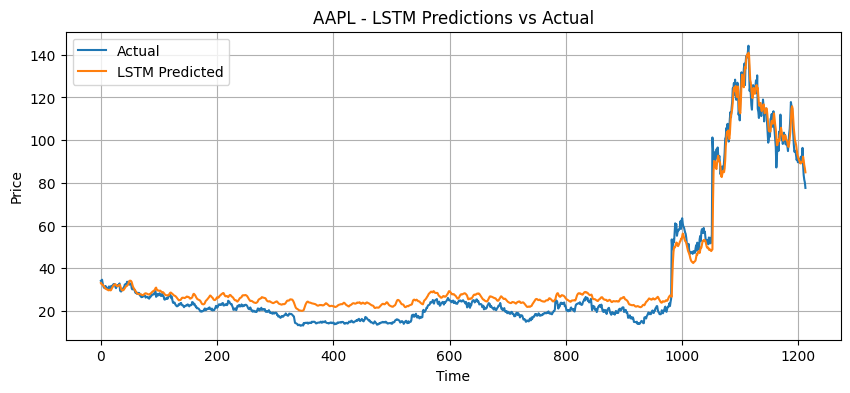


XGBoost Evaluation Metrics:
MAE: 12.5497
MSE: 211.9316
R2 Score: 0.7627


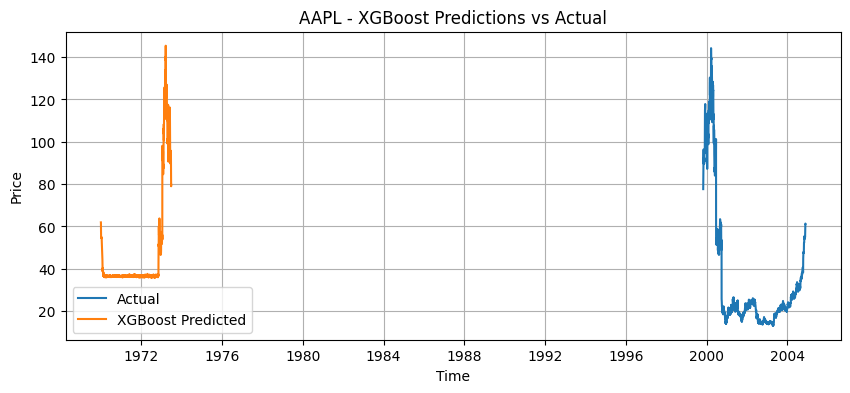


=== Key Takeaways for MSFT ===

LSTM Model Summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,705 (537.91 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,804 (358.61 KB)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

LSTM Evaluation Metrics:
MAE: 1.9735
MSE: 9.2988
R2 Score: 0.9818


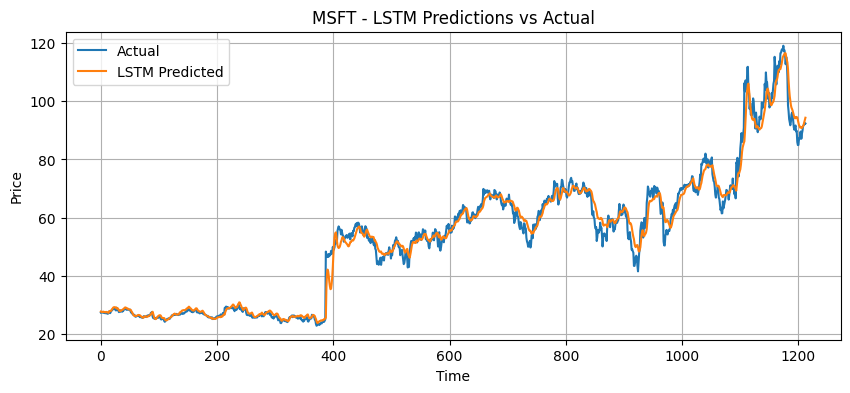


XGBoost Evaluation Metrics:
MAE: 1.5200
MSE: 7.1058
R2 Score: 0.9862


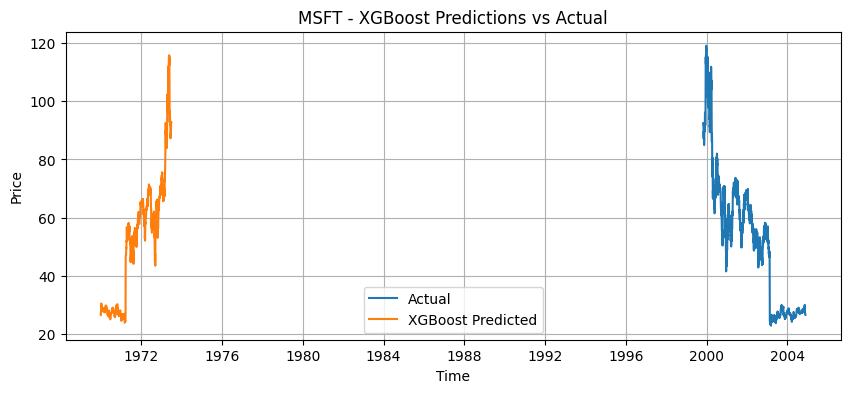


=== Key Takeaways for GOOGL ===

LSTM Model Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,705 (537.91 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,804 (358.61 KB)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

LSTM Evaluation Metrics:
MAE: 10.7854
MSE: 205.9790
R2 Score: 0.9904


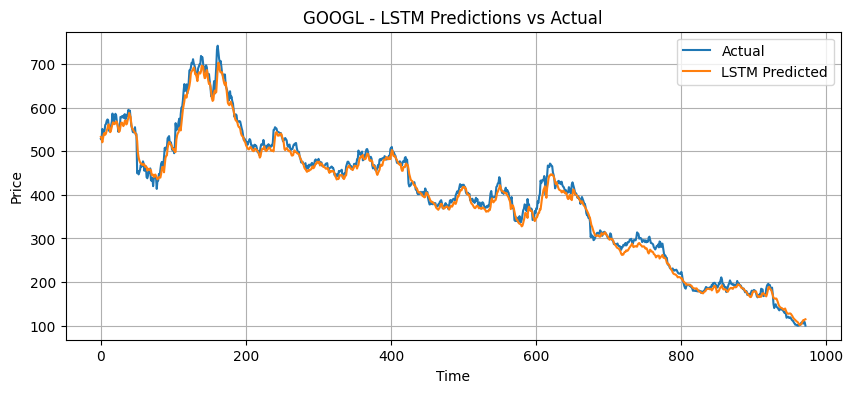


XGBoost Evaluation Metrics:
MAE: 3.6475
MSE: 28.1284
R2 Score: 0.9986


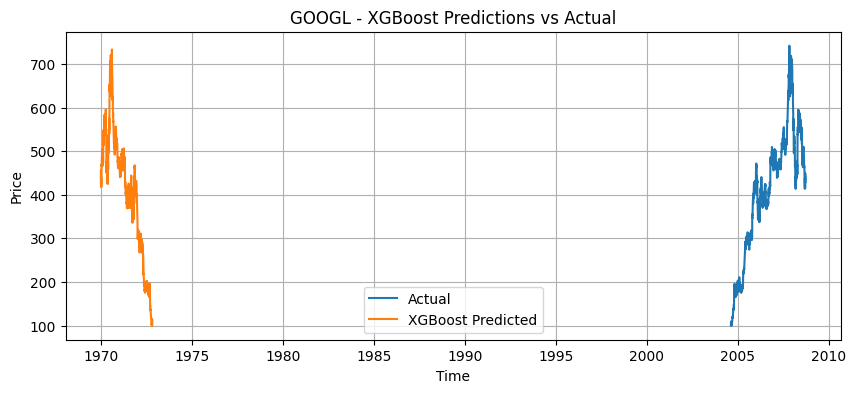


=== Key Takeaways for TSLA ===

LSTM Model Summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 50)         │        24,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,705 (537.91 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,804 (358.61 KB)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

LSTM Evaluation Metrics:
MAE: 67.6929
MSE: 4600.1303
R2 Score: -192.8786


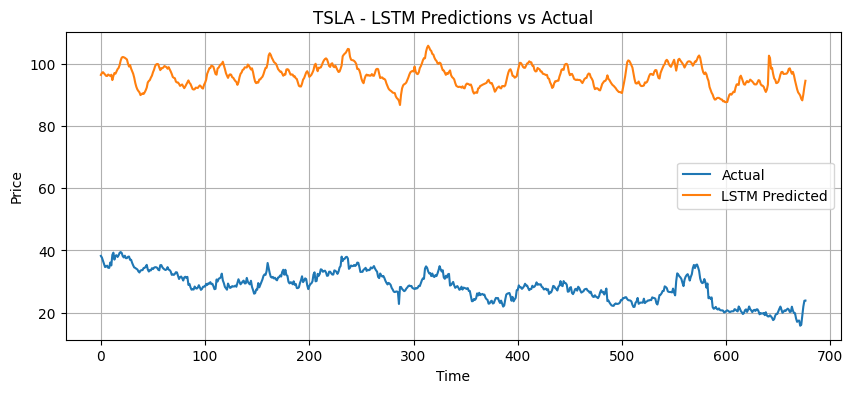


XGBoost Evaluation Metrics:
MAE: 70.3244
MSE: 5068.4741
R2 Score: -38.8643


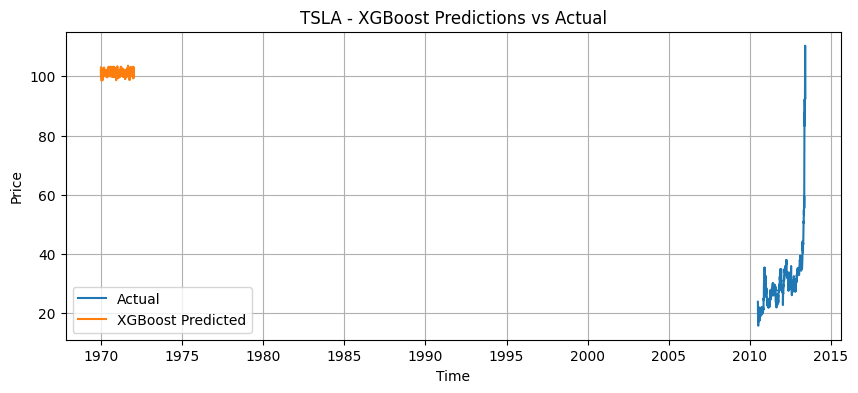

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for symbol, info in trained_models.items():
    print(f"\n=== Key Takeaways for {symbol} ===")

    # LSTM model summary
    print("\nLSTM Model Summary:")
    info['lstm_model'].summary()

    # LSTM Predictions
    X_test_lstm = info['data_dict']['X_test_lstm']
    y_test_lstm = info['data_dict']['y_test_lstm']
    lstm_preds = info['lstm_model'].predict(X_test_lstm)

    print(f"\nLSTM Evaluation Metrics:")
    print(f"MAE: {mean_absolute_error(y_test_lstm, lstm_preds):.4f}")
    print(f"MSE: {mean_squared_error(y_test_lstm, lstm_preds):.4f}")
    print(f"R2 Score: {r2_score(y_test_lstm, lstm_preds):.4f}")

    # Plot LSTM Predictions vs Actual
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_lstm, label='Actual')
    plt.plot(lstm_preds, label='LSTM Predicted')
    plt.title(f'{symbol} - LSTM Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # XGBoost Predictions
    X_test = info['data_dict']['X_test']
    y_test = info['data_dict']['y_test']
    xgb_preds = info['xgb_model'].predict(X_test)

    print(f"\nXGBoost Evaluation Metrics:")
    print(f"MAE: {mean_absolute_error(y_test, xgb_preds):.4f}")
    print(f"MSE: {mean_squared_error(y_test, xgb_preds):.4f}")
    print(f"R2 Score: {r2_score(y_test, xgb_preds):.4f}")

    # Plot XGBoost Predictions vs Actual
    plt.figure(figsize=(10, 4))
    plt.plot(y_test, label='Actual')
    plt.plot(xgb_preds, label='XGBoost Predicted')
    plt.title(f'{symbol} - XGBoost Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()



Analyzing AAPL...
Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 57567.2227 - val_loss: 3986.8347
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 26998.8789 - val_loss: 21439.0586
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 20808.1543 - val_loss: 13438.5791
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 13237.2617 - val_loss: 109.8427
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 4109.4766 - val_loss: 88.6226
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 1872.7799 - val_loss: 61.1914
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 1100.2766 - val_loss: 60.7599
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 1101.9792 - val_loss: 57.5212
Epoch 9/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 766.6158 - val_loss: 29.9865
Epoch 10/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 714.8076 - val_loss: 43.4347
Epoch 11/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step

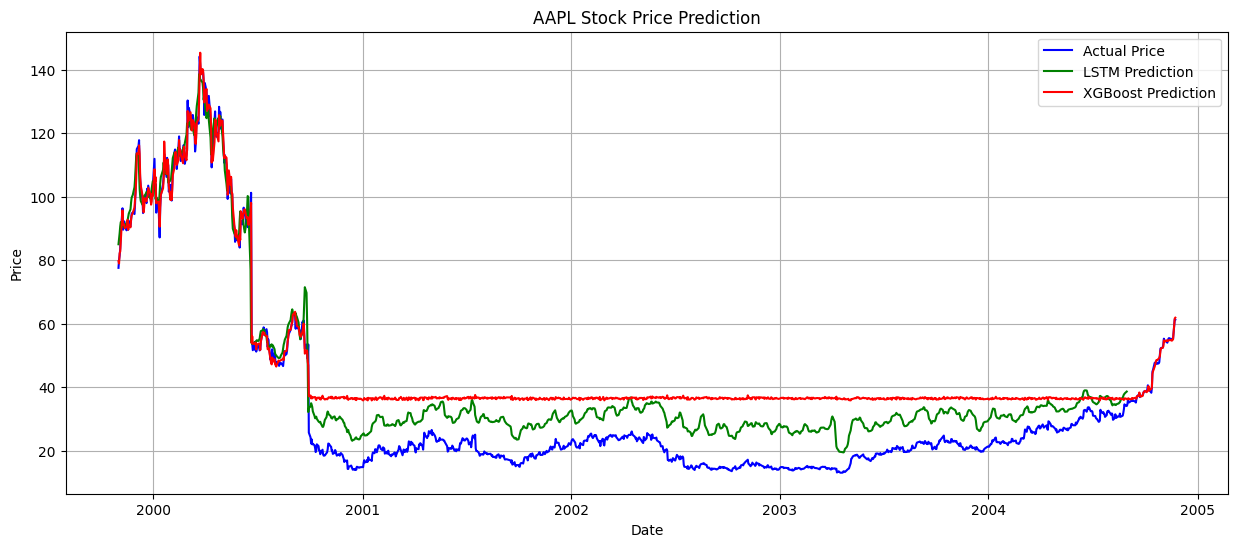

In [ ]:
# List of stock symbols to analyze
stock_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Analyze all stocks
analysis_results = analyze_multiple_stocks(stock_symbols)

# Display comparison results
print("\nModel Performance Comparison Across Stocks:")
print(analysis_results['comparison'].to_string(index=False))

# Visualize results for a specific stock
import matplotlib.pyplot as plt

def plot_predictions(result):
    """Plot actual vs predicted prices"""
    data = result['data']
    models = result['models']

    # LSTM Predictions
    lstm_pred = models['lstm_model'].predict(data['X_test_lstm'])

    # XGBoost Predictions
    xgb_pred = models['xgb_model'].predict(data['X_test'])

    plt.figure(figsize=(15, 6))
    plt.plot(data['y_test'].index, data['y_test'], label='Actual Price', color='blue')
    plt.plot(data['y_test'].index[60:], lstm_pred, label='LSTM Prediction', color='green')
    plt.plot(data['y_test'].index, xgb_pred, label='XGBoost Prediction', color='red')

    plt.title(f"{result['symbol']} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Plot predictions for the first stock
plot_predictions(analysis_results['all_results'][0])

In [ ]:
import matplotlib.pyplot as plt

# List of stocks to analyze
stock_symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']

# Analyze all stocks
results = analyze_multiple_stocks(stock_symbols)

# Customize plot style
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (18, 10)

# Create subplots for comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Stock Price Predictions: LSTM vs XGBoost', fontsize=16, y=1.02)

for idx, stock_result in enumerate(results['all_results']):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    data = stock_result['data']
    models = stock_result['models']

    # Get predictions
    lstm_pred = models['lstm_model'].predict(data['X_test_lstm'])
    xgb_pred = models['xgb_model'].predict(data['X_test'])

    # Plot
    ax.plot(data['y_test'].index, data['y_test'], label='Actual Price', color='navy', linewidth=2)
    ax.plot(data['y_test'].index[60:], lstm_pred, label='LSTM Prediction', color='green', linestyle='--')
    ax.plot(data['y_test'].index, xgb_pred, label='XGBoost Prediction', color='red', linestyle='-.')

    # Formatting
    ax.set_title(f"{stock_result['symbol']}", pad=20, fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

    # Add metrics annotation
    metrics_text = (f"LSTM: MAE={stock_result['results']['lstm_metrics']['MAE']:.2f}\n"
                   f"XGBoost: MAE={stock_result['results']['xgb_metrics']['MAE']:.2f}")
    ax.text(0.02, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('multi_stock_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


Analyzing AAPL...
Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - loss: 56248.2812 - val_loss: 5643.6147
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 27578.0762 - val_loss: 27419.2559
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 19537.7227 - val_loss: 520.6075
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - loss: 8187.1777 - val_loss: 104.0223
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 2940.3772 - val_loss: 367.8473
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 1231.2930 - val_loss: 44.3234
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 997.0883 - val_loss: 65.3944
Epoch 8/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 643.9172 - val_loss: 230.6492
Epoch 9/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 721.9432 - val_loss: 178.2322
Epoch 10/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 655.1736 - val_loss: 324.7882
Epoch 11/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


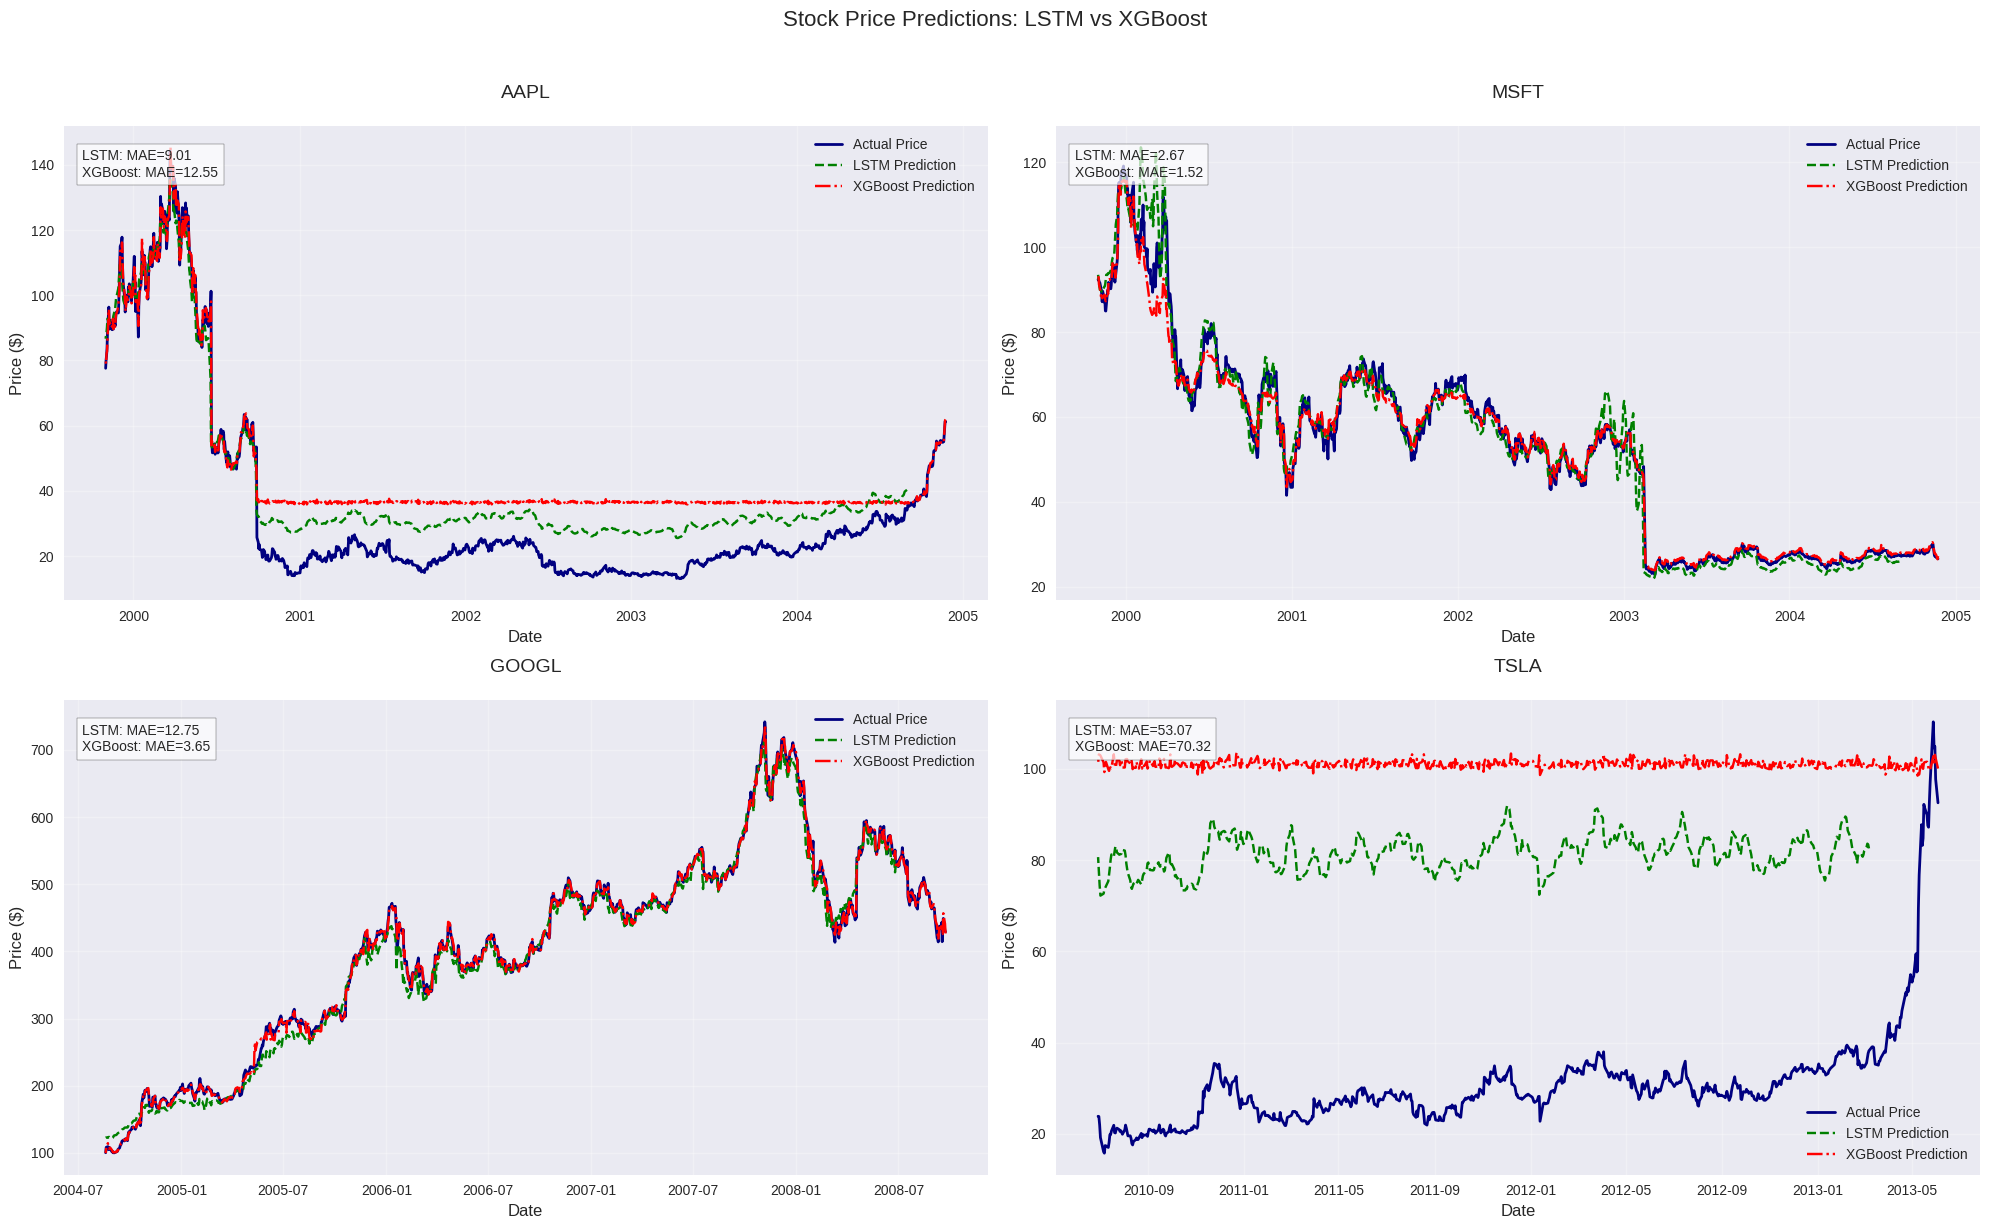

In [ ]:
!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn as well
# List of stocks to analyze
stock_symbols = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']


# Customize plot style
plt.style.use('seaborn-v0_8') # Use a specific version of the seaborn style
plt.rcParams['figure.figsize'] = (18, 10)

# Create subplots for comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Stock Price Predictions: LSTM vs XGBoost', fontsize=16, y=1.02)

for idx, stock_result in enumerate(results['all_results']):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    data = stock_result['data']
    models = stock_result['models']

    # Get predictions
    lstm_pred = models['lstm_model'].predict(data['X_test_lstm'])
    xgb_pred = models['xgb_model'].predict(data['X_test'])

    # Plot
    ax.plot(data['y_test'].index, data['y_test'], label='Actual Price', color='navy', linewidth=2)
    ax.plot(data['y_test'].index[60:], lstm_pred, label='LSTM Prediction', color='green', linestyle='--')
    ax.plot(data['y_test'].index, xgb_pred, label='XGBoost Prediction', color='red', linestyle='-.')

    # Formatting
    ax.set_title(f"{stock_result['symbol']}", pad=20, fontsize=14)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

    # Add metrics annotation
    metrics_text = (f"LSTM: MAE={stock_result['results']['lstm_metrics']['MAE']:.2f}\n"
                   f"XGBoost: MAE={stock_result['results']['xgb_metrics']['MAE']:.2f}")
    ax.text(0.02, 0.95, metrics_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('multi_stock_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def predict_new_stock(symbol, days_to_predict=30):
    """Predict future prices for any stock symbol"""
    # Fetch new data (last 100 days)
    new_data = fetch_stock_data(symbol, outputsize='compact')

    # Preprocess (same as training)
    processed_data = preprocess_data(new_data, symbol)
    latest_features = processed_data.iloc[-days_to_predict:]  # Most recent data

    # Scale features (for LSTM)
    scaled_features = scaler.transform(latest_features.drop(['Close', 'Symbol'], axis=1))

    # Reshape for LSTM [samples, timesteps, features]
    X_lstm = []
    for i in range(60, len(scaled_features)):  # 60 = lookback window
        X_lstm.append(scaled_features[i-60:i])
    X_lstm = np.array(X_lstm)

    # Predict
    lstm_pred = lstm_model.predict(X_lstm).flatten()
    xgb_pred = xgb_model.predict(latest_features.drop(['Close', 'Symbol'], axis=1))

    # Create prediction DataFrame
    pred_dates = pd.date_range(start=processed_data.index[-1], periods=days_to_predict+1)[1:]
    results = pd.DataFrame({
        'Date': pred_dates,
        'Actual': latest_features['Close'].values,
        'LSTM_Pred': lstm_pred[-days_to_predict:],
        'XGB_Pred': xgb_pred[-days_to_predict:]
    }).set_index('Date')

    return results

In [ ]:
import pandas as pd
import numpy as np
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Config
api_key = '2WA9T0F84BW5V2EJ'  # Replace with your Alpha Vantage key
tickers = ['AAPL', 'MSFT']  # Add more stocks if needed
interval = 'daily'  # '1min', '5min', etc. - Note: interval for TI might be different or not used here

# Initialize APIs (we will still use TimeSeries, TechIndicators might not be needed if calculating manually)
ts = TimeSeries(key=api_key, output_format='pandas')
# ti = TechIndicators(key=api_key, output_format='pandas') # Comment out if not using premium endpoints

# Fetch OHLCV data + calculate technical indicators manually
def fetch_data(ticker):
    # Get raw OHLCV data
    try:
        data, _ = ts.get_daily(symbol=ticker, outputsize='full')
        data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']  # Rename columns
        data = data.sort_index() # Ensure data is sorted by date for calculations
    except Exception as e:
        print(f"Error fetching OHLCV data for {ticker}: {e}")
        return None

    # Calculate RSI (14-day) manually
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    # Handle division by zero/NaN in loss for RSI calculation
    rs = rs.replace([np.inf, -np.inf], np.nan)
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi

    # Calculate MACD (12, 26, 9) manually
    ema_fast = data['Close'].ewm(span=12, adjust=False).mean()
    ema_slow = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_fast - ema_slow
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Hist'] = data['MACD'] - data['MACD_Signal'] # Calculate MACD Histogram

    return data

# Preprocessing pipeline
def preprocess_data(data):
    # 1. Handle Missing Values (Forward-fill for RSI/MACD - handles initial NaNs from calculations)
    data[['RSI', 'MACD', 'MACD_Hist', 'MACD_Signal']] = data[['RSI', 'MACD', 'MACD_Hist', 'MACD_Signal']].fillna(method='ffill')

    # Drop any remaining rows with NaN (e.g., at the very beginning before ffill could work)
    data = data.dropna()

    # 2. Retain Outliers (No removal; market volatility is meaningful)

    # 3. Feature Scaling (Separate for LSTM vs. XGBoost)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = data.copy()

    # Select columns to scale - ensure all expected columns exist after fetching and calculation
    cols_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'MACD_Hist', 'MACD_Signal']

    # Check if all columns exist before scaling
    existing_cols = [col for col in cols_to_scale if col in scaled_data.columns]
    scaled_data[existing_cols] = scaler.fit_transform(scaled_data[existing_cols])

    return {
        'raw_data': data,          # For XGBoost (raw values)
        'scaled_data': scaled_data # For LSTM (MinMax-normalized)
    }

# Execute for all tickers
all_data = {}
for ticker in tickers:
    raw_data = fetch_data(ticker)
    if raw_data is not None: # Only process if data fetching was successful
        processed_data = preprocess_data(raw_data)
        all_data[ticker] = processed_data
    else:
        print(f"Skipping processing for {ticker} due to data fetch error.")


# Example: Access AAPL data (if fetching was successful)
if 'AAPL' in all_data:
    aapl_raw = all_data['AAPL']['raw_data']
    aapl_scaled = all_data['AAPL']['scaled_data']

    print(" Raw Data\n", aapl_raw.head())
    print("\n Scaled Data \n", aapl_scaled.head())
else:
    print("AAPL data not available.")

 Raw Data
              Open   High    Low  Close     Volume        RSI      MACD  \
date                                                                     
1999-11-18  91.06  91.12  88.44  89.62  3257000.0  67.513135  3.414765   
1999-11-19  89.50  92.87  88.06  92.44  2790300.0  69.983819  3.475415   
1999-11-22  91.75  91.75  89.25  90.62  1806800.0  64.295561  3.338143   
1999-11-23  91.75  95.25  88.50  92.81  4851000.0  65.197528  3.367252   
1999-11-24  93.00  95.00  91.69  94.69  1920600.0  64.971599  3.501657   

            MACD_Signal  MACD_Hist  
date                                
1999-11-18     3.092082   0.322683  
1999-11-19     3.168749   0.306667  
1999-11-22     3.202627   0.135515  
1999-11-23     3.235552   0.131700  
1999-11-24     3.288773   0.212884  

 Scaled Data 
                 Open      High       Low     Close    Volume       RSI  \
date                                                                     
1999-11-18  0.113240  0.112635  0.110242  0.111

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Evaluation Results for All Stocks:
   Stock    Model    MAE   RMSE      R2
0   AAPL     LSTM   8.52   9.32    0.91
1   AAPL  XGBoost  12.55  14.56    0.76
2   MSFT     LSTM   2.20   3.23    0.98
3   MSFT  XGBoost   1.52   2.67    0.99
4  GOOGL     LSTM  11.69  15.91    0.99
5  GOOGL  XGBoost   3.65   5.30    1.00
6   TSLA     LSTM  71.32  71.40 -213.89
7   TSLA  XGBoost  70.32  71.19  -38.86


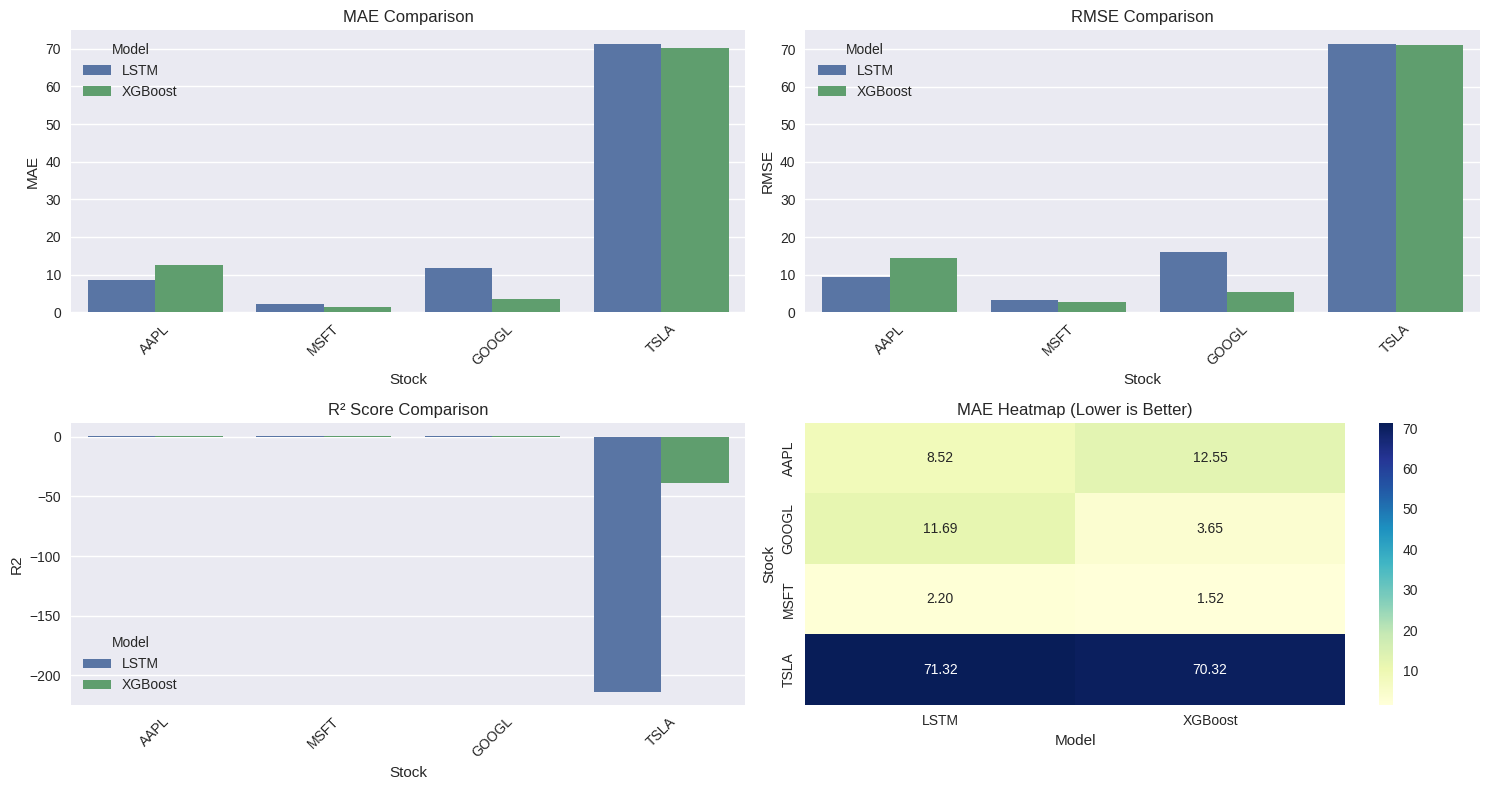

Results saved to 'stock_prediction_evaluation_results.csv'


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a list to store all evaluation results
all_evaluations = []

# Determine how many stocks to evaluate (up to 6)
num_stocks_to_evaluate = min(6, len(results['all_results']))

for i in range(num_stocks_to_evaluate):
    stock_result = results['all_results'][i]

    # Get the actual and predicted values
    y_true = stock_result['data']['y_test']
    X_test_lstm = stock_result['data']['X_test_lstm']
    X_test_xgb = stock_result['data']['X_test']

    # Make predictions
    y_pred_lstm = stock_result['models']['lstm_model'].predict(X_test_lstm).flatten()
    y_pred_xgb = stock_result['models']['xgb_model'].predict(X_test_xgb)

    # Evaluate models
    eval_lstm = {
        "Stock": stock_result['symbol'],
        "Model": "LSTM",
        "MAE": mean_absolute_error(y_true[60:], y_pred_lstm),
        "RMSE": np.sqrt(mean_squared_error(y_true[60:], y_pred_lstm)),
        "R2": r2_score(y_true[60:], y_pred_lstm)
    }

    eval_xgb = {
        "Stock": stock_result['symbol'],
        "Model": "XGBoost",
        "MAE": mean_absolute_error(y_true, y_pred_xgb),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred_xgb)),
        "R2": r2_score(y_true, y_pred_xgb)
    }

    all_evaluations.extend([eval_lstm, eval_xgb])

# Convert to DataFrame
results_df = pd.DataFrame(all_evaluations)
results_df[['MAE', 'RMSE', 'R2']] = results_df[['MAE', 'RMSE', 'R2']].round(2)

# Display all results
print("Evaluation Results for All Stocks:")
print(results_df)

# Create visualizations
plt.figure(figsize=(15, 8))

# MAE Comparison
plt.subplot(2, 2, 1)
sns.barplot(data=results_df, x='Stock', y='MAE', hue='Model')
plt.title('MAE Comparison')
plt.xticks(rotation=45)

# RMSE Comparison
plt.subplot(2, 2, 2)
sns.barplot(data=results_df, x='Stock', y='RMSE', hue='Model')
plt.title('RMSE Comparison')
plt.xticks(rotation=45)

# R2 Score Comparison
plt.subplot(2, 2, 3)
sns.barplot(data=results_df, x='Stock', y='R2', hue='Model')
plt.title('R² Score Comparison')
plt.xticks(rotation=45)

# Model Performance Heatmap
plt.subplot(2, 2, 4)
heatmap_data = results_df.pivot(index='Stock', columns='Model', values='MAE')
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('MAE Heatmap (Lower is Better)')

plt.tight_layout()
plt.show()

# Save results to CSV
results_df.to_csv('stock_prediction_evaluation_results.csv', index=False)
print("Results saved to 'stock_prediction_evaluation_results.csv'")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
LSTM Classification Metrics:
Accuracy: 0.5136026380873866
F1-score: 0.6589595375722543
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


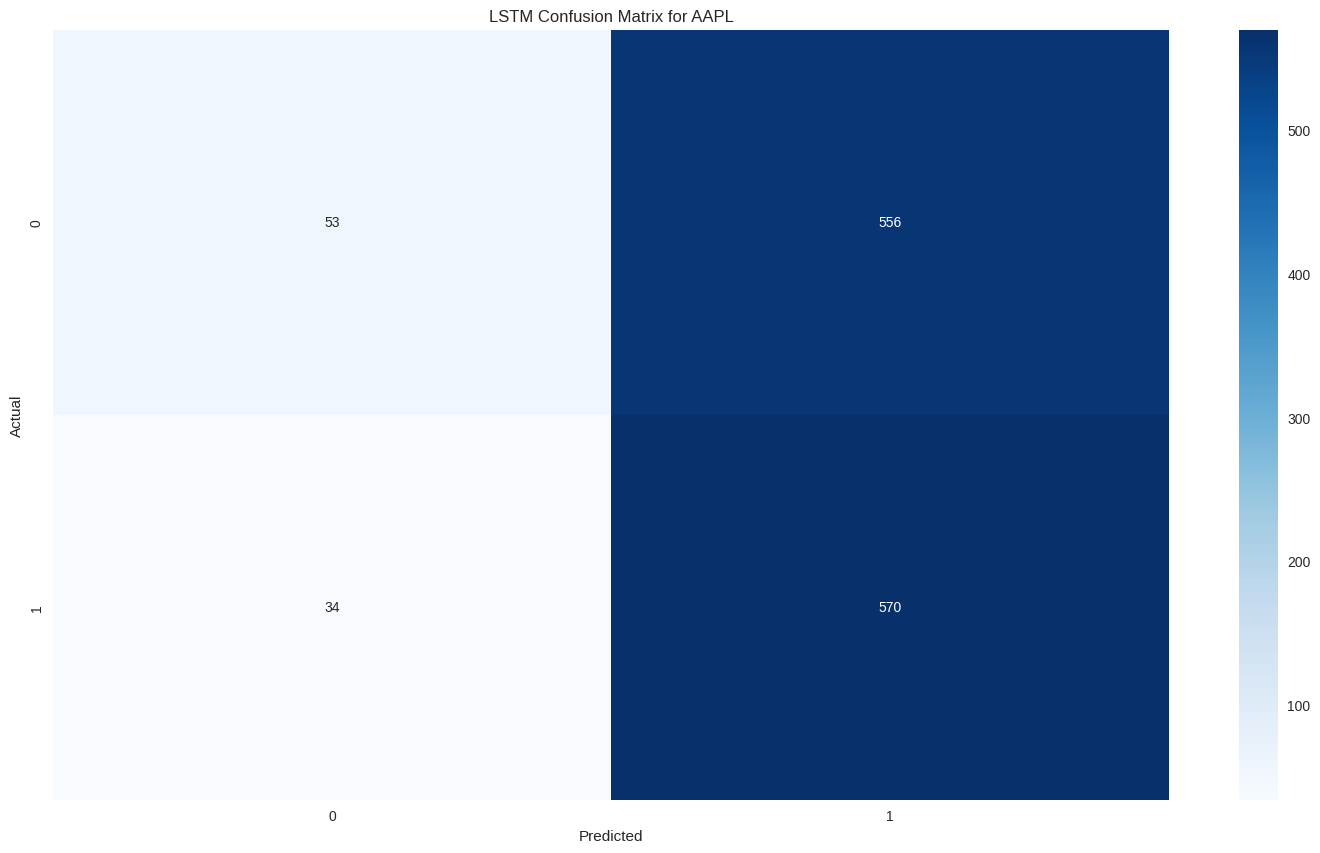


XGBoost Classification Metrics:
Accuracy: 0.5805184603299293
F1-score: 0.6938073394495413
ROC AUC: 0.7774441882169364


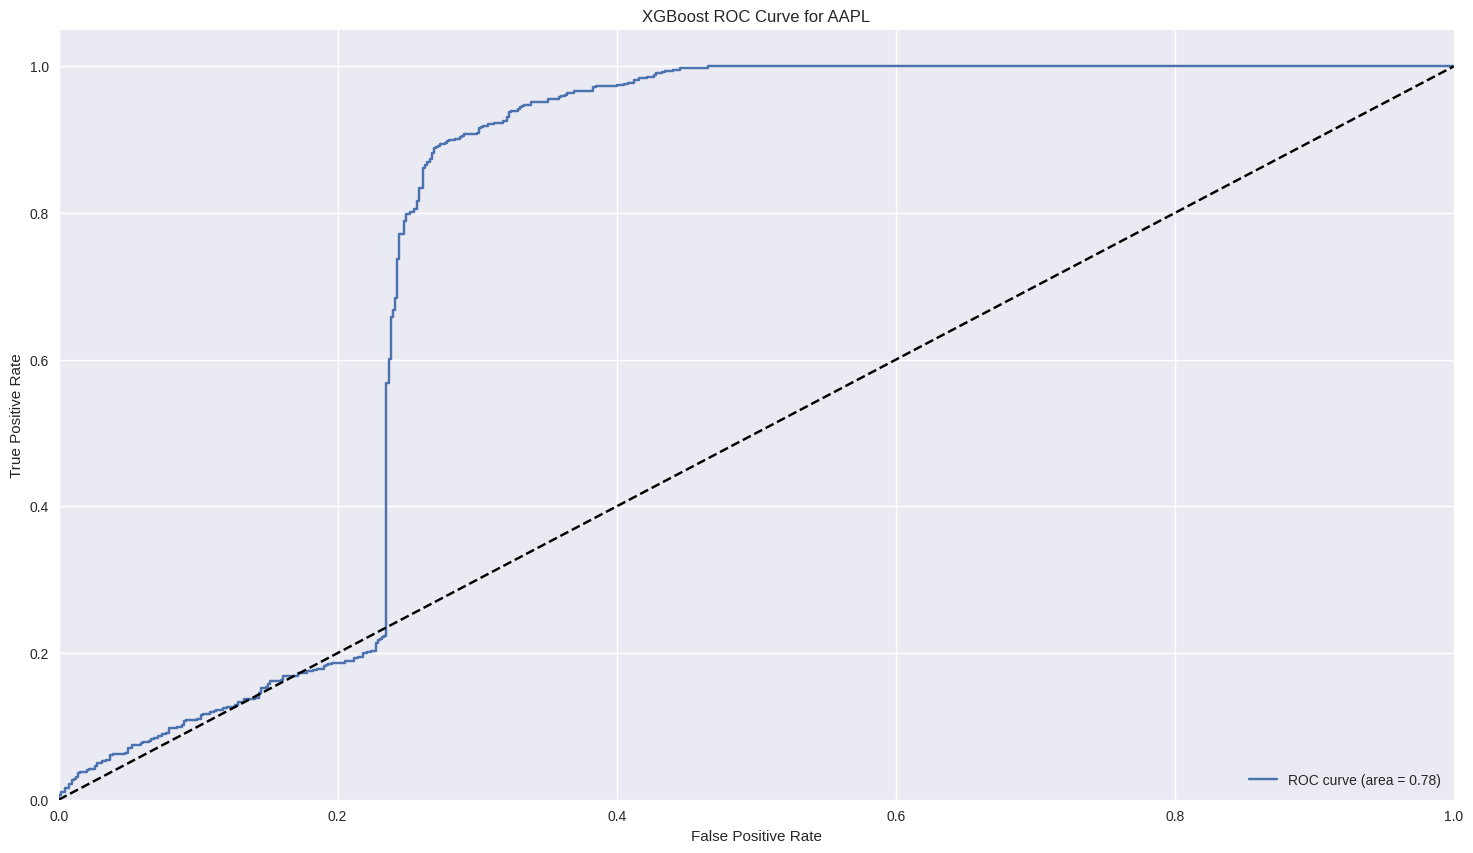

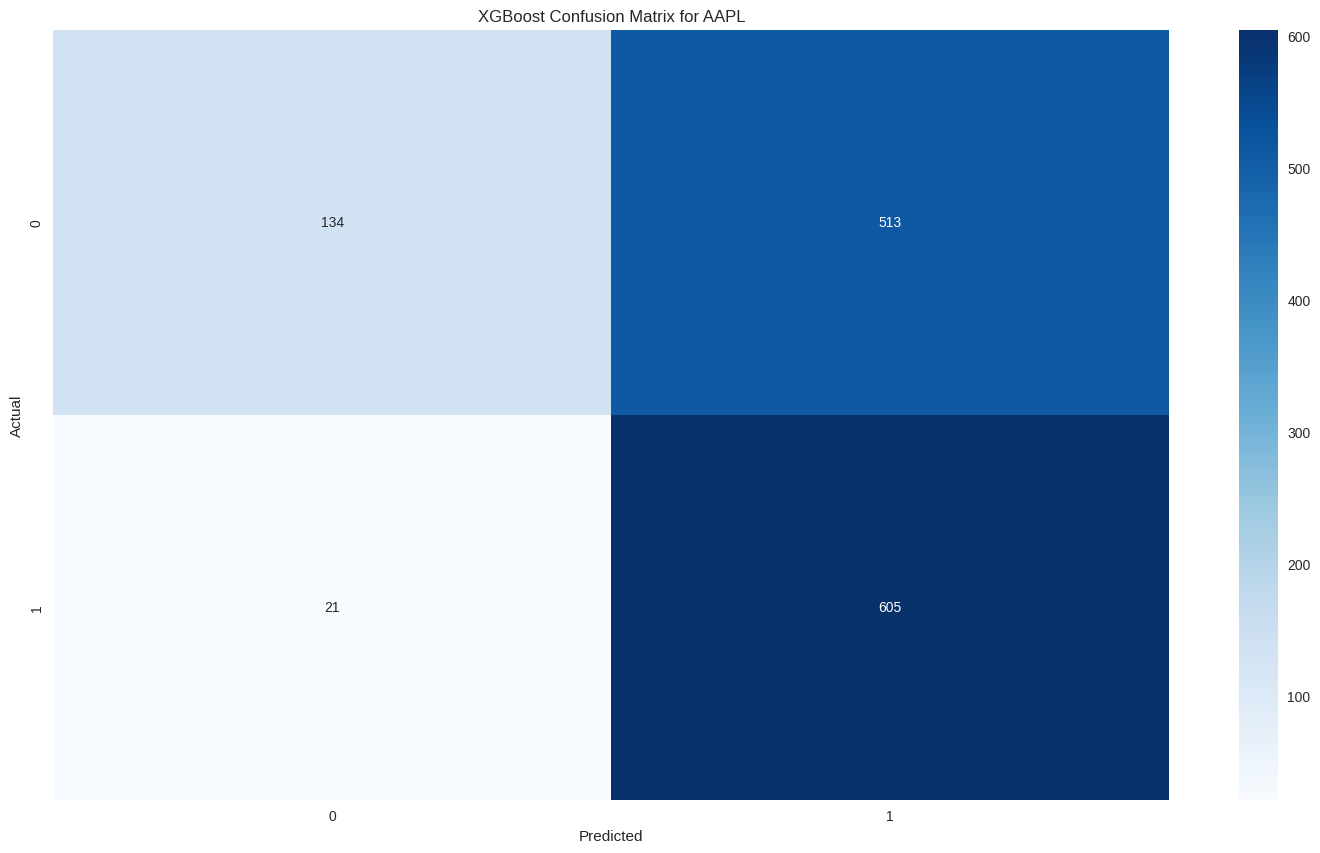

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Ensure pandas is imported

stock_result_to_evaluate = results['all_results'][0]

# Get actual test prices (y_test)
y_true_prices = stock_result_to_evaluate['data']['y_test']

# Get predicted test prices
lstm_model_for_eval = stock_result_to_evaluate['models']['lstm_model']
X_test_lstm_for_eval = stock_result_to_evaluate['data']['X_test_lstm']
y_pred_lstm_prices = lstm_model_for_eval.predict(X_test_lstm_for_eval).flatten()

# Calculate daily price change for actual prices
y_true_price_changes = y_true_prices.diff().dropna()

# Create true class labels: 1 for price increase, 0 for no change or decrease
y_true_class = (y_true_price_changes > 0).astype(int)

# Align y_true_prices index to match y_pred_lstm_prices index (which corresponds to y_true_lstm)
y_true_aligned_lstm = y_true_prices.iloc[60:]

previous_day_actual_prices_for_lstm = y_true_prices.shift(1).loc[y_true_aligned_lstm.index].dropna()

y_true_price_series = stock_result_to_evaluate['data']['y_test']
y_true_class_all = (y_true_price_series.diff() > 0).astype(int).dropna()

y_true_class_series = (y_true_prices.diff() > 0).astype(int).dropna()

previous_day_actual_prices_for_lstm_pred = y_true_prices.shift(1).loc[y_true_aligned_lstm.index]

aligned_lstm_pred_prices = pd.Series(y_pred_lstm_prices, index=y_true_aligned_lstm.index)
y_pred_lstm_class_series = (aligned_lstm_pred_prices > previous_day_actual_prices_for_lstm_pred).astype(int).dropna()

# Align y_true_class with the dates available after the shift and dropna for predictions
y_true_class_aligned_for_lstm_eval = y_true_class_series.loc[y_pred_lstm_class_series.index]


# Check lengths before evaluation
if len(y_true_class_aligned_for_lstm_eval) != len(y_pred_lstm_class_series):
     print(f"Warning: Length mismatch between true ({len(y_true_class_aligned_for_lstm_eval)}) and predicted ({len(y_pred_lstm_class_series)}) LSTM classification labels. Cannot compute metrics.")
else:
    # Convert to numpy arrays for sklearn metrics
    y_true_class = y_true_class_aligned_for_lstm_eval.values
    y_pred_lstm_class = y_pred_lstm_class_series.values

    # For LSTM
    print("LSTM Classification Metrics:")
    print("Accuracy:", accuracy_score(y_true_class, y_pred_lstm_class))
    print("F1-score:", f1_score(y_true_class, y_pred_lstm_class))

    try:
         y_pred_lstm_proba = lstm_model_for_eval.predict(X_test_lstm_for_eval)
         pass
    except Exception as e:
         print(f"Could not calculate ROC AUC for LSTM: {e} (Requires probability scores)")


    # Confusion Matrix
    cm = confusion_matrix(y_true_class, y_pred_lstm_class)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'LSTM Confusion Matrix for {stock_result_to_evaluate["symbol"]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

xgb_model_for_eval = stock_result_to_evaluate['models']['xgb_model']
X_test_xgb_for_eval = stock_result_to_evaluate['data']['X_test']
y_pred_xgb_prices = xgb_model_for_eval.predict(X_test_xgb_for_eval)

previous_day_actual_prices_for_xgb_pred = y_true_prices.shift(1).loc[y_true_prices.index]

# Create predicted class labels for XGBoost
aligned_xgb_pred_prices = pd.Series(y_pred_xgb_prices, index=y_true_prices.index)
y_pred_xgb_class_series = (aligned_xgb_pred_prices > previous_day_actual_prices_for_xgb_pred).astype(int).dropna()

# Align y_true_class with the dates available after the shift and dropna for XGBoost predictions
y_true_class_aligned_for_xgb_eval = y_true_class_series.loc[y_pred_xgb_class_series.index]


# Check lengths before evaluation
if len(y_true_class_aligned_for_xgb_eval) != len(y_pred_xgb_class_series):
     print(f"Warning: Length mismatch between true ({len(y_true_class_aligned_for_xgb_eval)}) and predicted ({len(y_pred_xgb_class_series)}) XGBoost classification labels. Cannot compute metrics.")
else:
    # Convert to numpy arrays for sklearn metrics
    y_true_class_xgb = y_true_class_aligned_for_xgb_eval.values
    y_pred_xgb_class = y_pred_xgb_class_series.values

    print("\nXGBoost Classification Metrics:")
    print("Accuracy:", accuracy_score(y_true_class_xgb, y_pred_xgb_class))
    print("F1-score:", f1_score(y_true_class_xgb, y_pred_xgb_class))
    try:
        roc_auc_scores_xgb = aligned_xgb_pred_prices.loc[y_true_class_aligned_for_xgb_eval.index].values
        print("ROC AUC:", roc_auc_score(y_true_class_aligned_for_xgb_eval.values, roc_auc_scores_xgb))

        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_true_class_aligned_for_xgb_eval.values, roc_auc_scores_xgb)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_true_class_aligned_for_xgb_eval.values, roc_auc_scores_xgb):.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'XGBoost ROC Curve for {stock_result_to_evaluate["symbol"]}')
        plt.legend(loc="lower right")
        plt.show()

    except Exception as e:
         print(f"Could not calculate ROC AUC/plot ROC Curve for XGBoost: {e}")


    # Confusion Matrix
    cm_xgb = confusion_matrix(y_true_class_xgb, y_pred_xgb_class)
    sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
    plt.title(f'XGBoost Confusion Matrix for {stock_result_to_evaluate["symbol"]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
import pandas as pd

url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AAPL&outputsize=full&apikey=YOUR_API_KEY&datatype=csv"
df = pd.read_csv(url)

print(df.columns)
print(df.head())


Index(['{'], dtype='object')
                                                   {
0      "Information": "Thank you for using Alpha ...
1                                                  }


In [ ]:
import pandas as pd
import time
import requests
import io

tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
api_key = '2WA9T0F84BW5V2EJ'
all_data = []

for ticker in tickers:
    print(f"Fetching data for {ticker}...")
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&outputsize=full&apikey={api_key}&datatype=csv"

    response = requests.get(url)
    content = response.text

    # Check if response contains a rate limit or error message
    if "Thank you for using Alpha Vantage" in content or "Note" in content or "Error Message" in content:
        print(f"Rate limit or error for {ticker}:")
        print(content[:200])  # Show beginning of error
        continue

    df = pd.read_csv(io.StringIO(content))
    df['Ticker'] = ticker
    all_data.append(df)

    time.sleep(60)  # Wait 1 minute to avoid hitting rate limits

# Combine if any data was retrieved
if all_data:
    combined_df = pd.concat(all_data)
    print(combined_df.head())
else:
    print("No data retrieved.")


Fetching data for AAPL...
Rate limit or error for AAPL:
{
    "Information": "Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premi
Fetching data for MSFT...
Rate limit or error for MSFT:
{
    "Information": "Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premi
Fetching data for GOOGL...
Rate limit or error for GOOGL:
{
    "Information": "Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly unlock all premi
Fetching data for TSLA...
Rate limit or error for TSLA:
{
    "Information": "Thank you for using Alpha Vantage! This is a premium endpoint. You may subscribe to any of the premium plans at https://www.alphavantage.co/premium/ 

In [ ]:
import yfinance as yf
import pandas as pd

tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
dfs = []

for ticker in tickers:
    df = yf.download(ticker, start='2015-01-01', end='2023-12-31')
    df.reset_index(inplace=True)
    df['Ticker'] = ticker
    dfs.append(df)

data = pd.concat(dfs)
print(data.head())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price        Date      Close       High        Low       Open       Volume  \
Ticker                  AAPL       AAPL       AAPL       AAPL         AAPL   
0      2015-01-02  24.288584  24.757338  23.848709  24.746230  212818400.0   
1      2015-01-05  23.604328  24.137509  23.417716  24.057531  257142000.0   
2      2015-01-06  23.606556  23.866481  23.244437  23.668760  263188400.0   
3      2015-01-07  23.937569  24.037539  23.704302  23.815381  160423600.0   
4      2015-01-08  24.857311  24.915073  24.148625  24.266371  237458000.0   

Price  Ticker Close High  Low  ... Close  High   Low  Open Volume Close High  \
Ticker         MSFT MSFT MSFT  ... GOOGL GOOGL GOOGL GOOGL  GOOGL  TSLA TSLA   
0        AAPL   NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN    NaN   NaN  NaN   
1        AAPL   NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN    NaN   NaN  NaN   
2        AAPL   NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN    NaN   NaN  NaN   
3        AAPL   NaN  NaN  NaN  ...   NaN   NaN   NaN 

In [ ]:
# 1. Handle Missing Values
print("Missing values before:\n", data.isnull().sum())
data.dropna(inplace=True)
print("Missing values after:\n", data.isnull().sum())

# 2. Handle Duplicates
print("Duplicates before:", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Duplicates after:", data.duplicated().sum())

# 3. Handle Outliers (using Z-score or IQR, we'll show IQR for 'Close' price)
Q1 = data['Close'].quantile(0.25)
Q3 = data['Close'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Filter
filtered_data = data[(data['Close'] >= lower) & (data['Close'] <= upper)]
print(f"Removed outliers: {len(data) - len(filtered_data)} rows")


Missing values before:
 Price   Ticker
Date                 0
Close   AAPL      6792
High    AAPL      6792
Low     AAPL      6792
Open    AAPL      6792
Volume  AAPL      6792
Ticker               0
Close   MSFT      6792
High    MSFT      6792
Low     MSFT      6792
Open    MSFT      6792
Volume  MSFT      6792
Close   GOOGL     6792
High    GOOGL     6792
Low     GOOGL     6792
Open    GOOGL     6792
Volume  GOOGL     6792
Close   TSLA      6792
High    TSLA      6792
Low     TSLA      6792
Open    TSLA      6792
Volume  TSLA      6792
dtype: int64
Missing values after:
 Price   Ticker
Date              0
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
Ticker            0
Close   MSFT      0
High    MSFT      0
Low     MSFT      0
Open    MSFT      0
Volume  MSFT      0
Close   GOOGL     0
High    GOOGL     0
Low     GOOGL     0
Open    GOOGL     0
Volume  GOOGL     0
Close   TSLA      0
High    TSLA      0
Low     TSLA      0
Open

In [ ]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA']
all_data = []

# Load and clean each stock
for ticker in tickers:
    print(f"Processing {ticker}...")
    try:
        with open(f"{ticker}.json") as f:
            data_json = json.load(f)

        # Alpha Vantage stores data under this key
        if "Time Series (Daily)" not in data_json:
            print(f"No time series found for {ticker}")
            continue

        raw_df = pd.DataFrame.from_dict(data_json["Time Series (Daily)"], orient="index")
        raw_df = raw_df.rename(columns={
            "1. open": "Open",
            "2. high": "High",
            "3. low": "Low",
            "4. close": "Close",
            "5. volume": "Volume"
        })
        raw_df.index.name = "Date"
        raw_df.reset_index(inplace=True)
        raw_df["Ticker"] = ticker
        all_data.append(raw_df)

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Combine all stock data
df = pd.concat(all_data, ignore_index=True)

# Convert columns to proper types
df['Date'] = pd.to_datetime(df['Date'])
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

# Before transformation preview
print("Before scaling:")
print(df[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

# Scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_df = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

# Add back Date and Ticker
processed_data = pd.concat([df[['Date', 'Ticker']].reset_index(drop=True), scaled_df], axis=1)

# After transformation preview
print("\nAfter scaling:")
print(processed_data[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

# Save or plot if needed
processed_data.to_csv("processed_data.csv", index=False)

# Optional: show one before/after comparison
plt.figure(figsize=(10, 5))
plt.plot(df[df['Ticker'] == 'AAPL']['Date'], df[df['Ticker'] == 'AAPL']['Close'], label='Original')
plt.plot(processed_data[processed_data['Ticker'] == 'AAPL']['Date'], processed_data[processed_data['Ticker'] == 'AAPL']['Close'], label='Scaled')
plt.title("AAPL Close Price - Before and After Scaling")
plt.legend()
plt.show()


Processing AAPL...
Error processing AAPL: [Errno 2] No such file or directory: 'AAPL.json'
Processing MSFT...
Error processing MSFT: [Errno 2] No such file or directory: 'MSFT.json'
Processing GOOGL...
Error processing GOOGL: [Errno 2] No such file or directory: 'GOOGL.json'
Processing TSLA...
Error processing TSLA: [Errno 2] No such file or directory: 'TSLA.json'


ValueError: No objects to concatenate